In [1]:
import pandas as pd
import requests
import json
import seaborn as sns

***
*Build the distribution of the visits number from bots and regular users of the Yandex.Metrica*
***

In [2]:
# metrics is a field for calculation, dimensions is a field for grouping  
url = 'https://api-metrika.yandex.net/stat/v1/data?'

# take visits (metrics) for Robots/People (dimensions)
visits = "metrics=ym:s:visits&dimensions=ym:s:date&dimensions=ym:s:isRobot&id=44147844"
url = url + visits

In [3]:
# request data by URL
result = requests.get(url)

# parse data to json
json_data = json.loads(result.text)

# build dataFrame
df = pd.DataFrame([(
                    i['dimensions'][0]['name'], i['dimensions'][1]['name'], i['metrics'][0]) 
                    for i in json_data['data']],
                    columns=['date', 'user_type', 'visits'])

In [ ]:
df.head

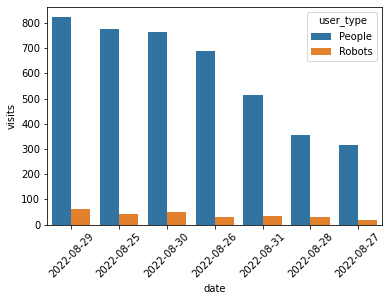

In [5]:
ax =sns.barplot(x="date", y="visits", data=df, hue='user_type')
ax.tick_params(axis='x', rotation=45)

***
*Determine the percentage of visits to the Yandex.Metrica from the Google Chrome browser*
***

In [6]:
url = 'https://api-metrika.yandex.net/stat/v1/data?'
visits = "metrics=ym:s:visits&dimensions=ym:s:date&dimensions=ym:s:isRobot&dimensions=ym:s:browser&filters=ym:s:date=='2022-08-29'&id=44147844"
url = url + visits

result = requests.get(url)
json_data = json.loads(result.text)
df = pd.DataFrame([(
                    i['dimensions'][0]['name'], i['dimensions'][1]['name'], i['dimensions'][2]['name'], i['metrics'][0]) 
                    for i in json_data['data']],
                    columns=['date', 'user_type', 'browser', 'visits'])

In [7]:
round((df.query('browser == "Google Chrome"').visits.sum() / df.visits.sum()) * 100, 0)

50.0

***
*Determine which browser has the largest share of site visits by bots from the total number of visits in this browser?*
***

In [8]:
category_visits = df.groupby(['browser', 'user_type'], as_index=False) \
            .agg({'visits': 'sum'}) \
            .pivot(index='browser', columns='user_type', values='visits') \
            .reset_index()
category_visits = category_visits.fillna(0)
category_visits['Robots_proportion'] = category_visits.Robots / (category_visits.People + category_visits.Robots)
category_visits.iloc[category_visits.Robots_proportion.idxmax()]

user_type
browser              MQQBrowser
People                      0.0
Robots                      1.0
Robots_proportion           1.0
Name: 10, dtype: object

***
*Create a column with a metric for the share of visits to the site for each of these cuts*
***

In [10]:
url = 'https://api-metrika.yandex.net/stat/v1/data?'
visits = "metrics=ym:s:visits&dimensions=ym:s:date&dimensions=ym:s:isRobot&dimensions=ym:s:browser&filters=ym:s:date=='2022-08-29'&id=44147844"
url = url + visits

result = requests.get(url)
json_data = json.loads(result.text)
df = pd.DataFrame([(
                    i['dimensions'][0]['name'], i['dimensions'][1]['name'], i['dimensions'][2]['name'], i['metrics'][0]) 
                    for i in json_data['data']],
                    columns=['date', 'user_type', 'browser', 'visits'])

In [13]:
prepared_df = df.groupby(['date', 'browser', 'user_type'], as_index=False).agg({'visits': 'sum'})
total_number_in_date = int(prepared_df.groupby('date', as_index=False) \
                .agg({'visits': 'sum'}) \
                .loc[prepared_df.date == '2022-08-29'].visits)
prepared_df['proportion'] = prepared_df['visits'].div(total_number_in_date)

In [14]:
round(prepared_df.loc[(prepared_df.browser == 'Safari') & (prepared_df.user_type == 'People')].proportion * 100, 1)

20    5.9
Name: proportion, dtype: float64